In [11]:
#ds_key = 'adni-100-csts2'
ds_key = 'adni-csts2-validtest'
from dataset_utils import adni_loader
import vte_runner

eval_data_params = vte_runner.named_vte_data_params[ds_key]
print(eval_data_params)
eval_data_params['load_vols'] = True
eval_ds = adni_loader.ADNIDataset(eval_data_params)
_ = eval_ds.load_dataset()


{'dataset_name': 'adni', 'source_name': 'centroidsubj2', 'target_name': 'subjs', 'final_test': False, 'n_validation': 100, 'valid_split': 0, 'exclude_from_valid_list': 'adni-100-csts2-valid.txt', 'unnormalized': True, 'masked': True, 'n_shot': 100, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 1, 'load_vols': True, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'warp_labels': True, 'n_dims': 3}
Loading adni dataset adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0
Params: {'dataset_name': 'adni', 'source_name': 'centroidsubj2', 'target_name': 'subjs', 'final_test': False, 'n_validation': 100, 'valid_split': 0, 'exclude_from_valid_list': 'adni-100-csts2-valid.txt', 'unnormalized'

In [3]:
do_final_test = False

%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader

gpu_ids = [3]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))



Load Segmenter experiment

In [4]:
import json
import os
import sys

sys.path.append('../cnn_utils')
import file_utils
from keras.models import load_model

from experiments_VTE import FewShotSegmentationExperimentClass
from keras.models import load_model
from keras.optimizers import Adam

sys.path.append('../voxelmorph')
import src.losses as vm_losses

sys.path.append('../medipy-lib')
import medipy.metrics as medipy_metrics

# load pretrained segmenter network
# ours
#model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1020/models/segmenter_unet_epoch8000_iter56000.h5'
ours_model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010/models/segmenter_unet_epoch4400_iter30800.h5'
ours_model_id = 'ours-indep'

# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_coupled/models/segmenter_unet_epoch5200_iter36400.h5'
# model_id = 'ours-coupled'

# randflow
hand_model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_flowaug-gen/models/segmenter_unet_epoch3600_iter25200.h5'
hand_model_id = 'hand-aug'

# # # 100 labeled examples
# # model_file = './experiments/FewShotSeg_adni-unnorm-masked_1ul_100l_ims160-192-1_arch32-32-64-64-128-128/models/segmenter_unet_epoch7000_iter49000.h5'
# # model_id = 'supervised'

# # # sas-aug
# # model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_sasaug100-vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000/models/segmenter_unet_epoch3500_iter24500.h5'
# # model_id = 'sas-aug'

# sas
sas_model_file = './experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000.h5'
sas_model_id = 'sas'

# # no-aug
# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128/models/segmenter_unet_epoch2500_iter17500.h5'
# model_id = 'no-aug'

# ours with ft on test set
# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_samp-adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0/models/segmenter_unet_epoch7700_iter53900.h5'
# model_id = 'ours-ft'

ourshand_model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_flowaug-gen/models/segmenter_unet_epoch9000_iter63000.h5'
ourshand_model_id = 'ours-indep-hand-aug'

load_model_files = [ourshand_model_file, hand_model_file]#, sas_model_file]
seg_models = []

for model_file in load_model_files:

    if 'experiments/voxelmorph' in model_file:  # SAS
        do_sas = True
        sys.path.append('../voxelmorph-sandbox')
        import voxelmorph.networks as vm_networks

        import tensorflow as tf
        from voxelmorph import dense_3D_spatial_transformer
        from keras.models import load_model

        sys.path.append('../neuron')
        import neuron.layers as nrn_layers
        import neuron.utils as nrn_utils

        import functools


        voxelmorph_model = load_model(
            model_file,
            custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                            'interp_upsampling': vm_networks.interp_upsampling,
                            'meshgrid': vm_networks.meshgrid,
                            'tf': tf,
                            'VecInt': nrn_layers.VecInt,
                            'SpatialTransformer': functools.partial(nrn_layers.SpatialTransformer, indexing='xy'),
                            'nrn_utils': nrn_utils,
                            'nrn_layers': nrn_layers,
                           },
            compile=False,
        )

        model_name = os.path.splitext(os.path.basename(model_file))[0]
    else:  # trained segmenter network
        do_sas = False
        model_name = os.path.basename(os.path.dirname(os.path.dirname(model_file))) + '_' + os.path.splitext(os.path.basename(model_file))[0]

        segmenter_model = load_model(model_file, custom_objects={'np': np}, compile=False)
        segmenter_model.compile(
            loss='categorical_crossentropy',
            metrics=[vm_losses.binary_dice],
            optimizer=Adam(0.0001),
        )
        seg_models.append(segmenter_model)

    print(model_name)

These are legacy implementations of spatial transformers. Recommend use of neuron.layers.SpatialTransformer() instead
FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_flowaug-gen_segmenter_unet_epoch9000_iter63000
FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_flowaug-gen_segmenter_unet_epoch3600_iter25200


In [5]:
# sas
sas_model_file = './experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000.h5'
sas_model_id = 'sas'    
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks

import tensorflow as tf
from voxelmorph import dense_3D_spatial_transformer
from keras.models import load_model

sys.path.append('../neuron')
import neuron.layers as nrn_layers
import neuron.utils as nrn_utils

import functools


vm_model = load_model(
    sas_model_file,
    custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                    'interp_upsampling': vm_networks.interp_upsampling,
                    'meshgrid': vm_networks.meshgrid,
                    'tf': tf,
                    'VecInt': nrn_layers.VecInt,
                    'SpatialTransformer': functools.partial(nrn_layers.SpatialTransformer, indexing='xy'),
                    'nrn_utils': nrn_utils,
                    'nrn_layers': nrn_layers,
                   },
    compile=False,
)

from networks import transform_network_utils
seg_warp_model = transform_network_utils.warp_model(
    img_shape=(160, 192, 224, 1),
    interp_mode='nearest',
    indexing='xy')



[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


In [16]:
# pick a subject, then look specifically at a label where we do well at 
import sys
import numpy as np
import IPython
import PIL
sys.path.append('../voxelmorph-sandbox')
from voxelmorph.visualization import brain_vis_utils

sys.path.append('../medipy-lib')
import medipy.metrics as medipy_metrics

import scipy.misc as spm

labels_to_vis = [
    #2, 41, # white matter
    #3, 42, # gray matter?
    #4, 43, # ventricles
    #11, 50, # caudate
    #12, 51, # putamen
    #60, 28, #ventralDC
    #8, 47, # cerebellum coretex,
    #10, 49, # thalami
    17, 53, # hippocampus
    ]
# labels_to_vis = None
slice_idx = 110
source_X = eval_ds.X_labeled_train[0]
source_Y = eval_ds.Y_labeled_train[0]
atlas_segs_img = brain_vis_utils.draw_segs_on_slice(source_X[:, :, slice_idx], 
                                                    source_Y[:, :, slice_idx], 
                                                           
                                                       include_labels=labels_to_vis,
                                                       draw_contours=True)

# print(atlas_segs_img.shape)
# atlas_segs_img = np.rot90(atlas_segs_img, k=3)
# IPython.display.display(PIL.Image.fromarray((atlas_segs_img[..., [1, 0, 2]]*255).astype(np.uint8)))



#ul_idxs_to_show = [2, 3, 25] +  
valid_idxs_to_show = list(range(50,100))

ours_preds = []    
hand_preds = []
sas_preds = []
input_ims = []
for i in valid_idxs_to_show:#range(10):
    print(i)
    target_X = eval_ds.X_labeled_valid[i]
    target_Y = eval_ds.Y_labeled_valid[i]
    input_ims.append(np.clip(target_X[:, :, slice_idx] * 1.5, 0., 1.))
    ours_preds.append(seg_models[0].predict(target_X[np.newaxis, :, :, slice_idx]))
    hand_preds.append(seg_models[1].predict(target_X[np.newaxis, :, :, slice_idx]))

    _, flow = vm_model.predict([source_X[np.newaxis], target_X[np.newaxis]])
    sas_preds.append(seg_warp_model.predict([target_Y[np.newaxis, ..., np.newaxis], flow]))


50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


50


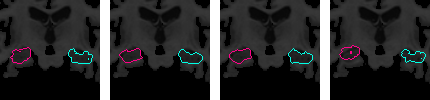

51


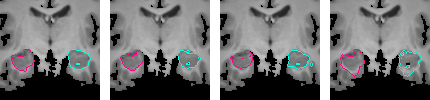

52


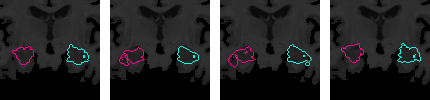

53


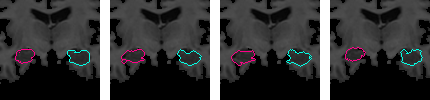

54


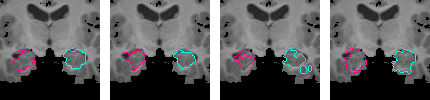

55


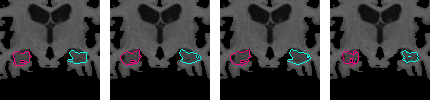

56


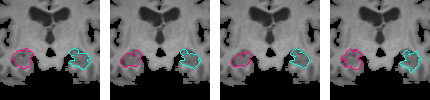

57


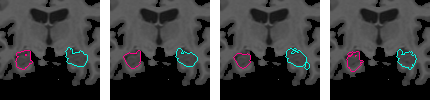

58


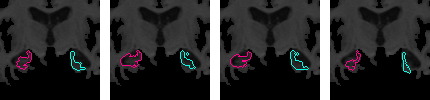

59


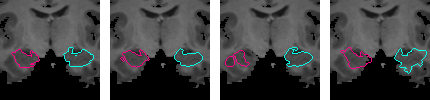

60


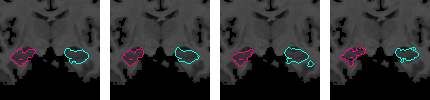

61


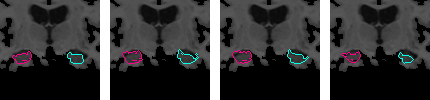

62


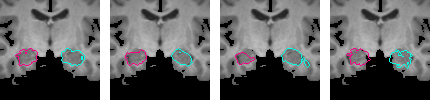

63


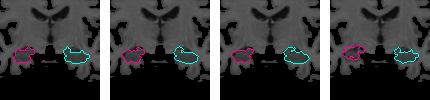

64


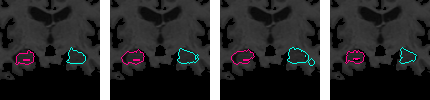

65


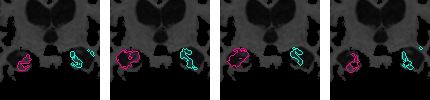

66


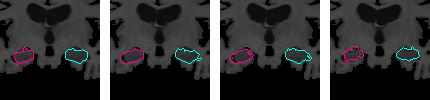

67


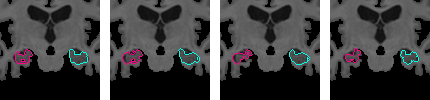

68


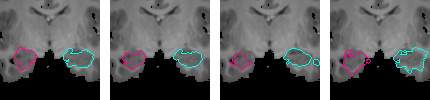

69


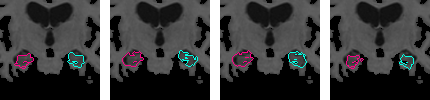

70


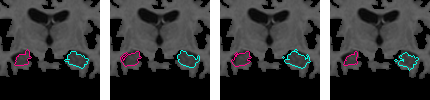

71


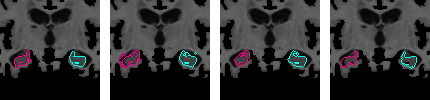

72


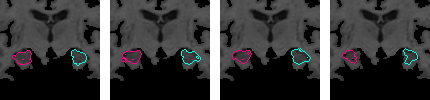

73


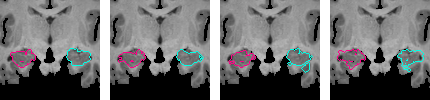

74


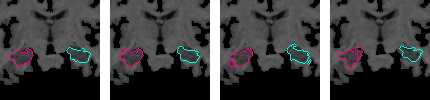

75


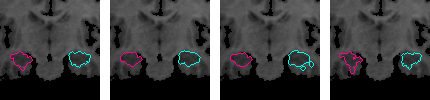

76


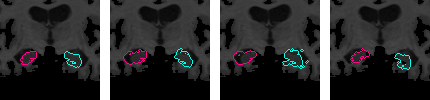

77


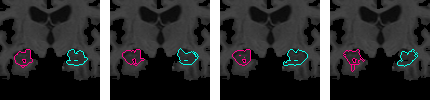

78


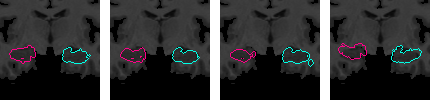

79


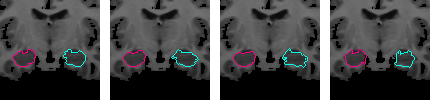

80


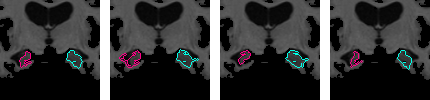

81


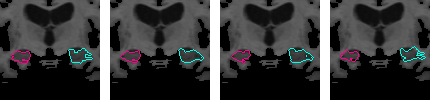

82


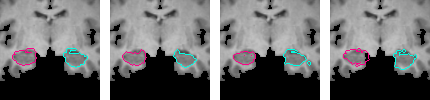

83


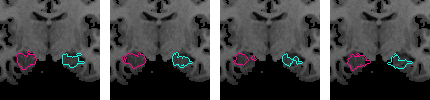

84


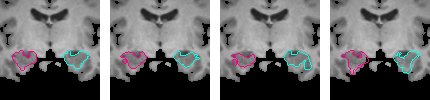

85


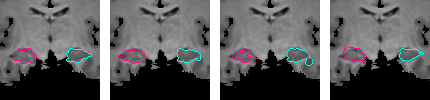

86


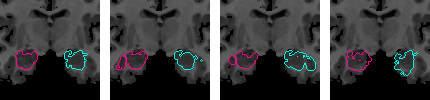

87


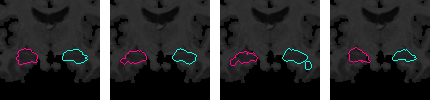

88


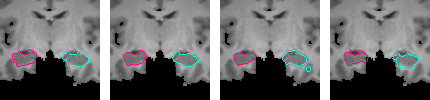

89


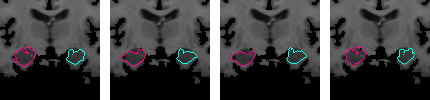

90


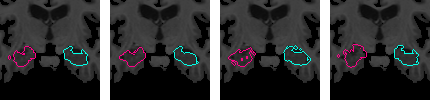

91


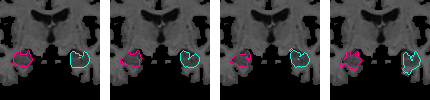

92


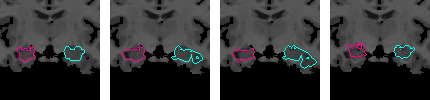

93


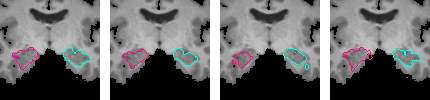

94


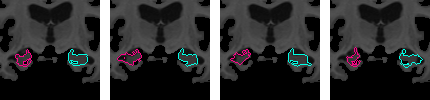

95


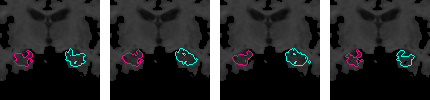

96


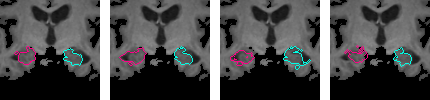

97


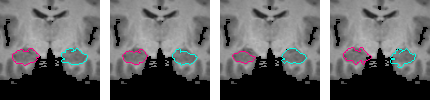

98


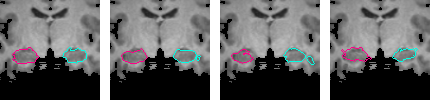

99


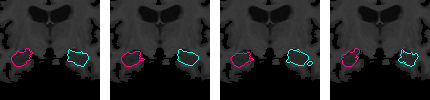

In [17]:
import classification_utils
import vte_runner
label_mapping = vte_runner.voxelmorph_labels



for i, idx in enumerate(valid_idxs_to_show):#range(10):
    print(idx)
    gt_segs_im = np.rot90(brain_vis_utils.draw_segs_on_slice(input_ims[i], 
                                                    eval_ds.Y_labeled_valid[idx, :, :, slice_idx],
                                                       include_labels=labels_to_vis,
                                                       draw_contours=True), 3)
    gt_segs_im = gt_segs_im[60:160, 30:-30]

    ours_segs_im = np.rot90(brain_vis_utils.draw_segs_on_slice(input_ims[i], 
                                                    classification_utils.onehot_to_labels(
                                                        ours_preds[i][0], 
                                                        label_mapping=label_mapping
                                                    ),
                                                       include_labels=labels_to_vis,
                                                       draw_contours=True), 3)
    ours_segs_im = ours_segs_im[60:160, 30:-30]

    hand_segs_im = np.rot90(brain_vis_utils.draw_segs_on_slice(input_ims[i], 
                                                    classification_utils.onehot_to_labels(
                                                        hand_preds[i][0], 
                                                        label_mapping=label_mapping
                                                    ),
                                                       include_labels=labels_to_vis,
                                                       draw_contours=True),3)
    hand_segs_im = hand_segs_im[60:160, 30:-30]

    
    sas_segs_im = np.rot90(brain_vis_utils.draw_segs_on_slice(input_ims[i], 
                                                    sas_preds[i][0, :, :, slice_idx], 
                                                       include_labels=labels_to_vis,
                                                       draw_contours=True),3)
    sas_segs_im = sas_segs_im[60:160, 30:-30]
    
    out_ims = [gt_segs_im, ours_segs_im, hand_segs_im, sas_segs_im]
    
    
    border = np.ones((out_ims[0].shape[0], 10, out_ims[0].shape[-1]))
    
    all_out_ims = [None] * (len(out_ims)* 2 - 1)
    all_out_ims[::2] = out_ims
    all_out_ims[1::2] = [border] * (len(out_ims) - 1)
    out_im = np.concatenate(all_out_ims, axis=1) * 255
    IPython.display.display(PIL.Image.fromarray((
       out_im[..., [1, 0, 2]]).astype(np.uint8)))
#     sas_segs_im = brain_vis_utils.draw_segs_on_slice(target_X[:, :, slice_idx], 
#                                                     sas_preds[i][0, :, :, slice_idx], 
#                                                        include_labels=labels_to_vis,
#                                                        draw_contours=True)
#     IPython.display.display(PIL.Image.fromarray((
#        sas_segs_im*255).astype(np.uint8)))

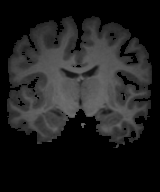

In [22]:
import classification_utils
import vte_runner
label_mapping = vte_runner.voxelmorph_labels



for i, idx in enumerate([59]):#range(10):
    im = np.clip(eval_ds.X_labeled_valid[idx, :, :, slice_idx, 0] * 1.4, 0. ,1.)
    IPython.display.display(PIL.Image.fromarray((
       np.rot90(im,3) * 255).astype(np.uint8)))


In [ ]:
do_final_test = False
# show what our labeled example looks like, as a sanity check
import IPython
import PIL
source_X = eval_ds.X_labeled_train[[0]]#adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_Y = eval_ds.Y_labeled_train[[0]]
print(eval_ds.files_labeled_train)

IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))
if do_final_test:
    print(eval_ds.files_labeled_test[:10])
    IPython.display.display(PIL.Image.fromarray((eval_ds.X_labeled_test[0, :, :, 64, 0]*255).astype(np.uint8)))
    IPython.display.display(PIL.Image.fromarray((eval_ds.Y_labeled_test[0, :, :, 64]*255).astype(np.uint8)))
    print(eval_ds.X_labeled_test.shape)


In [ ]:
label_mapping = vte_runner.voxelmorph_labels
from networks import segmenter_networks

# seg_exp.dataset.logger = seg_exp.logger
if do_final_test:
    eval_gen = eval_ds.gen_vols_batch(
            ['labeled_test'], batch_size=1, randomize=False,
    )

    n_eval_examples = eval_ds.params['n_test']

else:
    eval_gen = eval_ds.gen_vols_batch(
            ['labeled_valid'], batch_size=1, randomize=False,
    )

    n_eval_examples = eval_ds.params['n_validation']

if do_sas:
    eval_cces, eval_dice, eval_accs = segmenter_networks.eval_seg_sas_from_gen(
        sas_model=voxelmorph_model,
        atlas_vol=source_X, atlas_labels=source_Y,
        eval_gen=eval_gen, label_mapping=label_mapping,
        n_eval_examples=n_eval_examples, batch_size=10)
else:
    eval_cces, eval_dice, eval_accs = segmenter_networks.eval_seg_from_gen(
        segmenter_model=segmenter_model,
        eval_gen=eval_gen, label_mapping=label_mapping,
        n_eval_examples=n_eval_examples, batch_size=10)



In [ ]:
# save our test results in a mat file so that we can parse them later

In [ ]:
results_dir = './segmentation_test_results'
if '128' in model_name:
    short_model_name = model_name.split('128-128_')[1]
else:
    short_model_name = model_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
    
if do_final_test:
    mode='test'
else:
    mode='valid'

results_file = os.path.join(results_dir, '{}_{}_{}.mat'.format(eval_ds.display_name, mode, model_id))
print('Saved results to {}'.format(results_file))
import scipy.io as sio


sio.savemat(results_file, {
    'cce': eval_cces,
    'dice': eval_dice,
    'acc': eval_accs
    
})

In [ ]:
import os
n_eval_examples = eval_ds.params['n_validation']
mode='valid'

n_subjects = n_eval_examples
ds_name = '{}_{}_'.format(eval_ds.display_name, mode)
cce_per_result = []
dice_per_result = []
acc_per_result = []
result_names = []
for rfn in os.listdir(results_dir):
    if ds_name not in rfn:
        continue
    
    result = sio.loadmat(os.path.join(results_dir, rfn))
    result_name = os.path.splitext(os.path.basename(rfn))[0]
    result_name = result_name.split('valid_')[-1]
    print(result_name)
    print(result['cce'].shape)
    if result['cce'].shape[-1] < n_subjects:
        continue
    result_names.append(result_name)
    cce_per_result.append(result['cce'])
    acc_per_result.append(result['acc'])
    dice_per_result.append(result['dice'][np.newaxis])
print(result_names)
sort_results_by_name = ['supervised','ours-indep-hand-aug', 'ours-ft','ours-indep','ours-coupled', 'hand-aug', 'sas-aug', 'sas', 'no-aug']

sorted_acc = []
sorted_dice = []
for rn in sort_results_by_name:
    idx = result_names.index(rn)
    sorted_acc.append(acc_per_result[idx])
    sorted_dice.append(dice_per_result[idx])
result_names = sort_results_by_name
# result_names, cce_per_result, acc_per_result, dice_per_result = zip(*sorted(zip(result_names, cce_per_result, acc_per_result, dice_per_result)))

acc_per_result = np.concatenate(sorted_acc, axis=0)
dice_per_result = np.concatenate(sorted_dice, axis=0)


In [ ]:

for rn in result_names:
    print(rn)



In [ ]:
x = np.tile(np.reshape(range(n_subjects), (1, n_subjects)), (len(result_names), 1))
print(acc_per_result.shape)
import matplotlib.pyplot as plt
print(dice_per_result.shape)
plt.figure(figsize=(20,10))
for ri, rn in enumerate(result_names):
    x = range(n_subjects)
    
    plt.scatter(x, np.mean(dice_per_result[ri, :, 1:], axis=-1))
    plt.plot(x, np.tile(np.mean(dice_per_result[ri,:,1:]), (np.asarray(x).shape)))
    print('Result {}, dice mean {}, std {}'.format(rn,
        round(np.mean(dice_per_result[ri,:,1:]), 3), 
                                                   round(np.std(dice_per_result[ri,:,1:]),3)))
    print('{} ({})'.format(
        round(np.mean(dice_per_result[ri,:,1:]), 3), 
        round(np.std(dice_per_result[ri,:,1:]),3)))
    plt.ylim([0.4, 1.])
plt.legend(short_result_names)
plt.title('dice')

plt.grid()
plt.show()

plt.figure(figsize=(20,10))
for ri, rn in enumerate(result_names):
    x = range(n_subjects)
    
    plt.scatter(x, acc_per_result[ri])
    plt.plot(x, np.tile(np.mean(acc_per_result[ri]), (np.asarray(x).shape)))
    print('Result {}, acc mean {}, std {}'.format(rn, round(np.mean(acc_per_result[ri]),3), 
                                                  round(np.std(acc_per_result[ri]), 3)))
    print('{} ({})'.format(
        round(np.mean(acc_per_result[ri]),3), 
        round(np.std(acc_per_result[ri]), 3)))    
plt.legend(short_result_names)

plt.title('acc')
plt.grid()
plt.show()




In [ ]:
# improvement over sas
plt.figure(figsize=(20,10))
ref_dice = dice_per_result[result_names.index('sas')]
for ri, rn in enumerate(result_names):
    print('Result {}, dice improvement over sas mean {}, std {}'.format(
        rn, round(np.mean(dice_per_result[ri] - ref_dice),3), 
        round(np.std(dice_per_result[ri] - ref_dice), 3)))
    print('{} ({})'.format(
         round(np.mean(dice_per_result[ri] - ref_dice),3), 
        round(np.std(dice_per_result[ri] - ref_dice), 3)))   
    
    %plt.scatter(range(len(label_mapping)),np.mean(dice_per_result[ri] - ref_dice, axis=0))

In [ ]:
# print(len(eval_ds.files_labeled_test))
# for f in eval_ds.files_labeled_test:
#     print(os.path.basename(f))

In [ ]:
# show_idx = 17
# for i in [1]:#range(100):
#     show_idx = 10
#     print(i)
    
#     print(eval_ds.files_labeled_valid[show_idx])

#     data = np.load(eval_ds.files_labeled_valid[show_idx])
#     im = data['vol_data']
#     plt.imshow((im[:, :, 100]*255).astype(np.uint8))
#     print(eval_ds.X_labeled_valid.shape)
#     #plt.imshow((eval_ds.X_labeled_valid[show_idx, :, :, 100, 0]*255).astype(np.uint8))
#     IPython.display.display(PIL.Image.fromarray((eval_ds.X_labeled_valid[show_idx, :, :, 100, 0]*255).astype(np.uint8)))
#     IPython.display.display(PIL.Image.fromarray((eval_ds.Y_labeled_valid[show_idx, :, :, 100]*255).astype(np.uint8)))

In [ ]:
# for f in test_ds.all_files:
#     print(os.path.basename(f))